In [31]:
# imports
# from torchvision.datasets import MNIST
import numpy as np
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

## Least Squares Function

Main function of the assignment.

This is the function that calculates the least squares solution for a given matrix A and vector b. It returns the vector x that minimizes the 2-norm of Ax-b.

x is based on the formula: x = inv(A.T @ A) @ A.T @ b

Note that here I have used the @ operator to denote matrix multiplication. Also, the transpose of a matrix A is denoted by A.T. Finally, inv(A) denotes the inverse of a matrix A. Here I have used the pinv function from numpy.linalg to calculate the pseudo-inverse of A, rather than the inverse of A so that the function can handle non-square and singular matrices. (However, A.T @ A is always square and invertible, so this is not necessary here.)

In [32]:
def least_squares(A, b):
    x = np.linalg.pinv(A.T @ A) @ A.T @ b
    return x

## Question 4

Here first of all, we generate two random vectors p and q of length 100 sampled from uniform random distribution between [-1,1].

Then the target variable b is defined as pq + p^2 + q^2.

Now we generate 6 basis functions as provided in order to implement the gradient descent algorithm to find the optimal weights vector x.

Now, we use the least squares method to find the optimal weights vector x. The optimal weights vector x is given by the formula (A^T A)^-1 A^T b, where A is the matrix of basis functions and b is the target variable vector.

As we can see very easily that the target function is a linear combination of the basis functions, the mean squared error is very close to zero and the weights vector x is very close to [0,0,0,1,1,1] as expected.

In [33]:
# generate vectors p and q
p = np.random.uniform(-1, 1, 100)
q = np.random.uniform(-1, 1, 100)

# generate the target variable b
b = p * q + p**2 + q**2

# defining the 6 basis functions
f0 = np.ones(100)
f1 = p
f2 = q
f3 = p**2
f4 = q**2
f5 = p * q

# creating matrix A from the basis functions
A = np.column_stack((f0, f1, f2, f3, f4, f5))

# calling the least squares function to calculate the coefficient vector x
x = least_squares(A, b)

# calculating the mse and printing the results
mse = np.mean((A @ x - b)**2)
print("Coefficient vector x:", x)
print("Mean Squared Error (MSE):", mse)

Coefficient vector x: [-3.88578059e-16 -3.78169718e-16 -1.73472348e-16  1.00000000e+00
  1.00000000e+00  1.00000000e+00]
Mean Squared Error (MSE): 2.789171467766698e-31


## Question 8
### Note: This is the same question as 4, just that we use the analytical solution there and here we use the gradient descent algorithm.

Here first of all, we generate two random vectors p and q of length 100 sampled from uniform random distribution between [-1,1].

Then the target variable b is defined as pq + p^2 + q^2.

Now we generate 6 basis functions as provided in order to implement the gradient descent algorithm to find the optimal weights vector x.

Gradient descent algorithm is implemented using the cost function and the update weights function. x (here theta) is initialized as a random vector of length 6.

The learning rate is set as 0.01 so that the algorithm converges to the optimal weights vector and the number of iterations is set as 50000. The cost graph is plotted to see how the cost function decreases with the number of iterations.

As we can see very easily that the target function is a linear combination of the basis functions, the mean squared error is very close to zero and the weights vector x (or theta) is very close to [0,0,0,1,1,1] as expected.

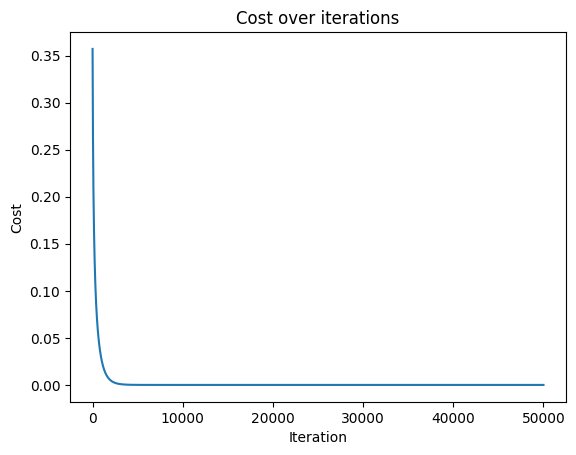

Coefficient vector x: [4.12528093e-14 9.20212288e-15 3.83306763e-15 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
Mean Squared Error (MSE): 9.671992032423715e-28


In [34]:
# generate vectors p and q
p = np.random.uniform(-1, 1, 100)
q = np.random.uniform(-1, 1, 100)

# generate the target variable b
b = p * q + p**2 + q**2

# defining the 6 basis functions
f0 = np.ones(100)
f1 = p
f2 = q
f3 = p**2
f4 = q**2
f5 = p * q

# creating matrix A from the basis functions
A = np.column_stack((f0, f1, f2, f3, f4, f5))

# gradient descent functions
# cost function
def cost(x,y,theta):
    return np.sum((x @ theta - y)**2)/(2*len(y))

# gradient descent function which updates theta
def gradient_descent(x,y,theta,learning_rate):
    return theta - learning_rate * x.T @ (x @ theta - y) / len(y)

# doing the gradient descent and plotting the cost function over iterations
# random initial theta
theta = np.random.randn(6)
# print("Initial theta:", theta)

learning_rate = 0.01
num_iterations = 50000
cost_history = np.zeros(num_iterations)

for i in range(num_iterations):
    theta = gradient_descent(A,b,theta,learning_rate)
    cost_history[i] = cost(A,b,theta)
plt.plot(cost_history)
plt.title("Cost over iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

# calculating the mse and printing the results
mse = np.mean((A @ theta - b)**2)
print("Coefficient vector x:", theta)
print("Mean Squared Error (MSE):", mse)

## Question 9

Here, based on the given data, we have to fit 3 piece wise polynomial functions on the interval [0,1] and [1,2] and [2,3] respectively for f1, f2 and f3.

It is given that f1 is degree 2 polynomial, f2 is degree 3 polynomial and f3 is degree 2 polynomial. Further, to impose continuity and differentiability at the boundaries, some additional constraints are added.

f1(1) = f2(1) and f2(2) = f3(2) and f2'(2) = f3'(2)

Now, we have to find the optimal weights vector x1, x2 and x3 for f1, f2 and f3 respectively, using the least squares method. 

We get,
f1(x) = 4.00 + -3.00x + 1.00x^2

f2(x) = 1.00 + 0.00x + -2.00x^2 + 3.00x^3

f3(x) = -35.00 + 24.00x + 1.00x^2

We see that the required polynomials also satisfy the given constraints. (Note that f1'(1) != f2'(1), but it is not our constraint.)

Finally, the data points and the fitted polynomials are plotted to see how well the polynomials fit the data, it can be seen that our polynomials fit the data very well.

Function for part 1 = 4.00 + -3.00x + 1.00x^2
Function for part 2 = 1.00 + 0.00x + -2.00x^2 + 3.00x^3
Function for part 3 = -35.00 + 24.00x + 1.00x^2

Constraints:
f1(1) = 2.00
f2(1) = 2.00
f2(2) = 17.00
f3(2) = 17.00
f2'(2) = 28.00
f3'(2) = 28.00


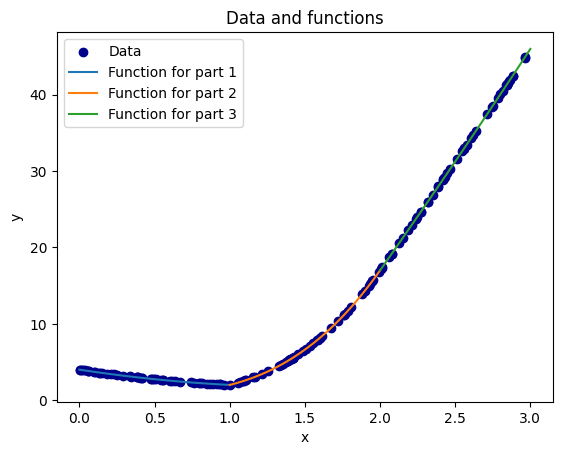

In [49]:
# loading the data
data = pd.read_csv("q9.csv")
data = data.values

# dividing the data into three parts
part_1 = data[(data[:, 0] >= 0) & (data[:, 0] <= 1)]
part_2 = data[(data[:, 0] > 1) & (data[:, 0] <= 2)]
part_3 = data[(data[:, 0] > 2) & (data[:, 0] <= 3)]

# defining the evaluation function
def f(params, x):
    return np.polyval(params, x)

# least squares function for polynomial regression which returns the parameters
def least_squares_poly(part, degree):
    x = part[:, 0]
    y = part[:, 1]
    X = np.vander(x, degree + 1)

    params = least_squares(X, y)
    return params

# calculating the parameters for the 3 parts
params_1 = least_squares_poly(part_1, 2)
params_2 = least_squares_poly(part_2, 3)
params_3 = least_squares_poly(part_3, 2)

# printing the functions
print("Function for part 1 = {:.2f} + {:.2f}x + {:.2f}x^2".format(params_1[2], params_1[1], params_1[0]))
print("Function for part 2 = {:.2f} + {:.2f}x + {:.2f}x^2 + {:.2f}x^3".format(params_2[3], params_2[2], params_2[1], params_2[0]))
print("Function for part 3 = {:.2f} + {:.2f}x + {:.2f}x^2".format(params_3[2], params_3[1], params_3[0]))

print("\nConstraints:")

# check continuity
print("f1(1) = {:.2f}".format(f(params_1, 1)))
print("f2(1) = {:.2f}".format(f(params_2, 1)))
print("f2(2) = {:.2f}".format(f(params_2, 2)))
print("f3(2) = {:.2f}".format(f(params_3, 2)))

# check differentiability
print("f2'(2) = {:.2f}".format(f(np.polyder(params_2), 2)))
print("f3'(2) = {:.2f}".format(f(np.polyder(params_3), 2)))

# plotting the data and the functions to compare
plt.scatter(data[:, 0], data[:, 1], label="Data", color="darkblue")

x = np.linspace(0, 1, 100)
plt.plot(x, f(params_1, x), label="Function for part 1")
x = np.linspace(1, 2, 100)
plt.plot(x, f(params_2, x), label="Function for part 2")
x = np.linspace(2, 3, 100)
plt.plot(x, f(params_3, x), label="Function for part 3")

plt.title("Data and functions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()